In [1]:
import re
import os
from shutil import copyfile
import numpy as np
import hypernetx as hnx
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import importlib
import inequality_classifier
import generate_polytope
import networkx as nx
import itertools as it
from networkx.algorithms import isomorphism as iso
import importlib
import spanning_tree as st

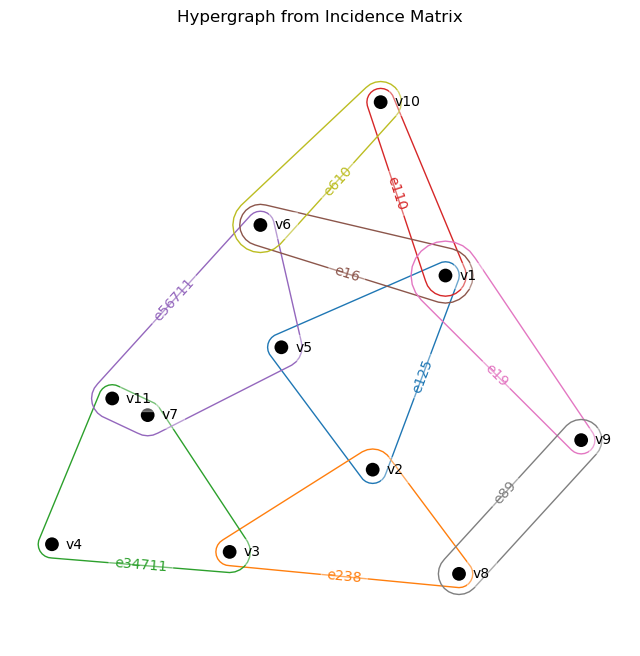

In [2]:
incidence = "incidence.txt"
inc_matrix = np.loadtxt(incidence, dtype=int)

edge_dict = {}
for row in inc_matrix:
    vertex_indices = [i + 1 for i, val in enumerate(row) if val == 1]  
    edge_name = 'e' + ''.join(str(i) for i in vertex_indices)        
    nodes = [f"v{i}" for i in vertex_indices]
    edge_dict[edge_name] = set(nodes)

H = hnx.Hypergraph(edge_dict)

hnx.draw(
    H,
    with_edge_labels=True,
    layout=nx.spring_layout,       
    layout_kwargs={'seed': 8}            
)
plt.title("Hypergraph from Incidence Matrix")
plt.show()

st.edge_dict = edge_dict
st.inc_matrix = inc_matrix
st.FIXED_EDGE_ORDER = list(edge_dict.keys())

In [ ]:
base_name = "incidence"
filename_poi, n_vertices, n_edges = generate_polytope.generate_ieq_from_incidence(base_name)



In [4]:
st.n_vertices = n_vertices
st.n_edges = n_edges
vertex_range = range(1, n_vertices + 1)
edge_range = range(n_vertices + 1, n_vertices + n_edges + 1)

classified = inequality_classifier.classify_poi_ieq_file("MPG11,9.poi.ieq", vertex_range, edge_range)
inequality_classifier.count_standard_vs_nonstandard(classified)

results1, summary1 = inequality_classifier.run_rank_from_classified(classified, vertex_range, edge_range,
                                            solver="ECOS", tol=1e-7, verbose=True)

(  1) (  1)                                          -x12                                      <= 0 ==> nu (-x_e ≤ 0)
(  2) (  2)                                              - x13                                 <= 0 ==> nu (-x_e ≤ 0)
(  3) (  3)                                                   -x14                             <= 0 ==> nu (-x_e ≤ 0)
(  4) (  4)                                                       -x15                         <= 0 ==> nu (-x_e ≤ 0)
(  5) (  5)                                                           - x16                    <= 0 ==> nu (-x_e ≤ 0)
(  6) (  6)                                                                - x17               <= 0 ==> nu (-x_e ≤ 0)
(  7) (  7)                                                                     - x18          <= 0 ==> nu (-x_e ≤ 0)
(  8) (  8)                                                                          - x19     <= 0 ==> nu (-x_e ≤ 0)
(  9) (  9)                                             

In [5]:
vertex_range = range(1, n_vertices+1)
edge_range   = range(n_vertices+1, n_vertices+n_edges+1)

edge_sets = inequality_classifier.edge_sets_from_incidence_matrix(inc_matrix, vertex_range, edge_range)


In [6]:
# First, create dictionaries with classification and rank information
results_dicts = []
for i, (_, ln, coeffs, rhs, label) in enumerate(classified):
    # Base dictionary with inequality info
    d = {
        "line": ln,
        "coeffs": coeffs,
        "rhs": rhs,
        "category": label
    }
    
    # Add rank information if available
    if i < len(results1):
        # results1[i] contains the rank-1 decomposition info
        r1_info = results1[i].get('r1', {})
        d['in_rank1'] = r1_info.get('in_rank1', False)  # True if rank-1
        d['ub_opt'] = r1_info.get('ub_opt')  # Optimal value from decomposition
        d['u'] = r1_info.get('u')  # Multipliers for standard inequalities
    
    results_dicts.append(d)

# Run the family annotations
results_dicts = inequality_classifier.annotate_running_intersection(results_dicts, vertex_range, edge_range, edge_sets, verbose=False)
results_dicts = inequality_classifier.annotate_odd_beta_cycle(results_dicts, vertex_range, edge_range, edge_sets, verbose=False)
results_dicts = inequality_classifier.annotate_flower(results_dicts, vertex_range, edge_range, edge_sets, verbose=False)



In [7]:
inequality_classifier.analyze_unclassified_rank1(results_dicts, classified)


Analyzing unclassified rank-1 inequalities:
--------------------------------------------------------------------------------

Inequality 1:
  ( 51) - x1              - x6   - x8- x9        -x12+ x13        + x16+ x17+ x18+ x19     <= 0
  Optimal value: 0.666667

  Standard inequalities with significant multipliers:
    #1 [nu (-x_e ≤ 0)] (coef=0.666667):
      (  1)                                          -x12                                      <= 0
    #10 [delta (-x_v + x_e ≤ 0)] (coef=0.666667):
      ( 10) - x1                                                                + x18          <= 0
    #11 [delta (-x_v + x_e ≤ 0)] (coef=0.666667):
      ( 11) - x1                                                           + x17               <= 0
    #14 [delta (-x_v + x_e ≤ 0)] (coef=0.333333):
      ( 14)     - x2                                     + x13                                 <= 0
    #19 [delta (-x_v + x_e ≤ 0)] (coef=0.333333):
      ( 19)               - x5            

In [8]:
results_dicts

[{'line': '(  1)                                          -x12                                      <= 0',
  'coeffs': {12: -1},
  'rhs': 0,
  'category': 'nu (-x_e ≤ 0)',
  'in_rank1': False,
  'ub_opt': None,
  'u': None},
 {'line': '(  2)                                              - x13                                 <= 0',
  'coeffs': {13: -1},
  'rhs': 0,
  'category': 'nu (-x_e ≤ 0)',
  'in_rank1': False,
  'ub_opt': None,
  'u': None},
 {'line': '(  3)                                                   -x14                             <= 0',
  'coeffs': {14: -1},
  'rhs': 0,
  'category': 'nu (-x_e ≤ 0)',
  'in_rank1': False,
  'ub_opt': None,
  'u': None},
 {'line': '(  4)                                                       -x15                         <= 0',
  'coeffs': {15: -1},
  'rhs': 0,
  'category': 'nu (-x_e ≤ 0)',
  'in_rank1': False,
  'ub_opt': None,
  'u': None},
 {'line': '(  5)                                                           - x16                    

In [9]:
if __name__ == "__main__":
    incidence = "incidence.txt"
    edge_dict, inc_matrix = st.read_incidence_to_edge_dict(incidence)

    RESTRICT_TO_F = False

    for f in edge_dict.keys():
        print(f"\n=== Focus edge {f} ===")
        Gf = st.build_intersection_graph_on_N(edge_dict, f, restrict_to_f=RESTRICT_TO_F)

        print("Nodes:", list(Gf.nodes()))
        print("Edges:")
        for u, v, d in Gf.edges(data=True):
            print(f"  {u} -- {v} via {sorted(d['S'], key=lambda x: int(x[1:]))}")

        trees = st.all_spanning_trees(Gf)
        print(f"Total spanning trees: {len(trees)}")

        for k, T in enumerate(trees, 1):
            info = st.describe_tree_vs_graph(Gf, T)
            print(f" Tree {k}:")
            print("   kept:", info["tree_edges"])
            print("   removed:", info["removed_edges"])


=== Focus edge e125 ===
Nodes: ['e238', 'e34711', 'e110', 'e56711', 'e16', 'e19', 'e89', 'e610']
Edges:
  e238 -- e34711 via ['v3']
  e238 -- e89 via ['v8']
  e34711 -- e56711 via ['v7', 'v11']
  e110 -- e16 via ['v1']
  e110 -- e19 via ['v1']
  e110 -- e610 via ['v10']
  e56711 -- e16 via ['v6']
  e56711 -- e610 via ['v6']
  e16 -- e19 via ['v1']
  e16 -- e610 via ['v6']
  e19 -- e89 via ['v9']
Total spanning trees: 108
 Tree 1:
   kept: [('e110', 'e16'), ('e110', 'e19'), ('e110', 'e610'), ('e16', 'e56711'), ('e238', 'e34711'), ('e238', 'e89'), ('e34711', 'e56711')]
   removed: [('e16', 'e19', ['v1']), ('e16', 'e610', ['v6']), ('e19', 'e89', ['v9']), ('e56711', 'e610', ['v6'])]
 Tree 2:
   kept: [('e110', 'e16'), ('e110', 'e19'), ('e110', 'e610'), ('e238', 'e34711'), ('e238', 'e89'), ('e34711', 'e56711'), ('e56711', 'e610')]
   removed: [('e16', 'e19', ['v1']), ('e16', 'e56711', ['v6']), ('e16', 'e610', ['v6']), ('e19', 'e89', ['v9'])]
 Tree 3:
   kept: [('e110', 'e16'), ('e110', 'e1

In [10]:
for f in edge_dict:
    Gf = st.build_intersection_graph_on_N(edge_dict, f, restrict_to_f=False)
    dups, trees = st.check_tree_duplicates(Gf)
    print(f"f={f} -> duplicates: {dups}")
    if dups:
        break

Total trees: 108, Unique keys: 108, Duplicates: 0
f=e125 -> duplicates: 0
Total trees: 209, Unique keys: 209, Duplicates: 0
f=e238 -> duplicates: 0
Total trees: 725, Unique keys: 725, Duplicates: 0
f=e34711 -> duplicates: 0
Total trees: 244, Unique keys: 244, Duplicates: 0
f=e110 -> duplicates: 0
Total trees: 140, Unique keys: 140, Duplicates: 0
f=e56711 -> duplicates: 0
Total trees: 136, Unique keys: 136, Duplicates: 0
f=e16 -> duplicates: 0
Total trees: 159, Unique keys: 159, Duplicates: 0
f=e19 -> duplicates: 0
Total trees: 732, Unique keys: 732, Duplicates: 0
f=e89 -> duplicates: 0
Total trees: 452, Unique keys: 452, Duplicates: 0
f=e610 -> duplicates: 0


In [11]:
filename = "MPG11,9.poi.ieq" 
A, c = st.build_lp_matrices(filename, n_vertices=11, n_edges=9)

(  1) (  1)                                          -x12                                      <= 0 ==> nu (-x_e ≤ 0)
(  2) (  2)                                              - x13                                 <= 0 ==> nu (-x_e ≤ 0)
(  3) (  3)                                                   -x14                             <= 0 ==> nu (-x_e ≤ 0)
(  4) (  4)                                                       -x15                         <= 0 ==> nu (-x_e ≤ 0)
(  5) (  5)                                                           - x16                    <= 0 ==> nu (-x_e ≤ 0)
(  6) (  6)                                                                - x17               <= 0 ==> nu (-x_e ≤ 0)
(  7) (  7)                                                                     - x18          <= 0 ==> nu (-x_e ≤ 0)
(  8) (  8)                                                                          - x19     <= 0 ==> nu (-x_e ≤ 0)
(  9) (  9)                                             

In [12]:
# Build all spanningtree inequalities
A_cand, b_cand, metas, var_names, var_index = st.collect_all_spanningtree(
    edge_dict, inc_matrix,
    enumerate_reps=True,   # enumerate all v_{pe} choices
    dedupe=True            # keep one copy per identical (a,b)
)

print(f"Generated {A_cand.shape[0]} distinct spanning-tree inequalities candidates.")

for i in range(A_cand.shape[0]):
    a = A_cand[i]
    b = int(b_cand[i])

    # make a readable inequality string
    parts = []
    for j, coef in enumerate(a):
        c = int(coef)
        if c == 0:
            continue
        name = var_names[j]
        parts.append(f"{'+' if c>0 else '-'}{name}" if abs(c)==1 else f"{c:+d}{name}")
    ineq_str = " ".join(parts) + f" ≤ {b}"

    # compact meta
    m = metas[i]
    reps = list(m.get("rep_assignment", {}).values())
    tree = m.get("tree_edges", [])
    Pf   = m.get("Pf")
    f    = m.get("f")

    print(f"({i+1}) {ineq_str}")
    print(f"     f={f}  Pf={Pf}  reps={reps}  tree={tree}")


Generated 4415 distinct spanning-tree inequalities candidates.
(1) -2v1 -v3 -v6 -v7 -v8 -v10 -e125 +e238 +e34711 +e110 +e56711 +e16 +e19 +e89 +e610 ≤ 0
     f=e125  Pf=[]  reps=['v8', 'v1', 'v1', 'v10', 'v3', 'v7', 'v6']  tree=[('e110', 'e16'), ('e110', 'e19'), ('e110', 'e610'), ('e16', 'e56711'), ('e238', 'e34711'), ('e238', 'e89'), ('e34711', 'e56711')]
(2) -2v1 -v3 -v6 -v8 -v10 -v11 -e125 +e238 +e34711 +e110 +e56711 +e16 +e19 +e89 +e610 ≤ 0
     f=e125  Pf=[]  reps=['v8', 'v1', 'v1', 'v10', 'v3', 'v11', 'v6']  tree=[('e110', 'e16'), ('e110', 'e19'), ('e110', 'e610'), ('e16', 'e56711'), ('e238', 'e34711'), ('e238', 'e89'), ('e34711', 'e56711')]
(3) -2v1 -v3 -v6 -v7 -v8 -v10 -e125 +e238 +e34711 +e110 +e56711 +e16 +e19 +e89 +e610 ≤ 0
     f=e125  Pf=[]  reps=['v8', 'v1', 'v1', 'v10', 'v3', 'v7', 'v6']  tree=[('e110', 'e16'), ('e110', 'e19'), ('e110', 'e610'), ('e238', 'e34711'), ('e238', 'e89'), ('e34711', 'e56711'), ('e56711', 'e610')]
(4) -2v1 -v3 -v6 -v8 -v10 -v11 -e125 +e238 +e3471

In [14]:
if __name__ == "__main__":
    filename_ieq = "MPG11,9.poi.ieq"
    A_porta, b_porta = st.build_lp_matrices(filename_ieq, n_vertices=n_vertices, n_edges=n_edges)

    A_cand, b_cand, metas, var_names, var_index = st.collect_all_spanningtree(
        edge_dict, inc_matrix, enumerate_reps=True, dedupe=True
    )

    _ = st.compare_spanningtree_with_porta(A_cand, b_cand, A_porta, b_porta, var_names)

(  1) (  1)                                          -x12                                      <= 0 ==> nu (-x_e ≤ 0)
(  2) (  2)                                              - x13                                 <= 0 ==> nu (-x_e ≤ 0)
(  3) (  3)                                                   -x14                             <= 0 ==> nu (-x_e ≤ 0)
(  4) (  4)                                                       -x15                         <= 0 ==> nu (-x_e ≤ 0)
(  5) (  5)                                                           - x16                    <= 0 ==> nu (-x_e ≤ 0)
(  6) (  6)                                                                - x17               <= 0 ==> nu (-x_e ≤ 0)
(  7) (  7)                                                                     - x18          <= 0 ==> nu (-x_e ≤ 0)
(  8) (  8)                                                                          - x19     <= 0 ==> nu (-x_e ≤ 0)
(  9) (  9)                                             

In [15]:
if __name__ == "__main__":
    print("Starting dominance analysis...")
    results = st.test_dominance_with_porta()

Starting dominance analysis...
(  1) (  1)                                          -x12                                      <= 0 ==> nu (-x_e ≤ 0)
(  2) (  2)                                              - x13                                 <= 0 ==> nu (-x_e ≤ 0)
(  3) (  3)                                                   -x14                             <= 0 ==> nu (-x_e ≤ 0)
(  4) (  4)                                                       -x15                         <= 0 ==> nu (-x_e ≤ 0)
(  5) (  5)                                                           - x16                    <= 0 ==> nu (-x_e ≤ 0)
(  6) (  6)                                                                - x17               <= 0 ==> nu (-x_e ≤ 0)
(  7) (  7)                                                                     - x18          <= 0 ==> nu (-x_e ≤ 0)
(  8) (  8)                                                                          - x19     <= 0 ==> nu (-x_e ≤ 0)
(  9) (  9)              